In [1]:
# Code from: https://github.com/gokriznastic/HybridSN
%load_ext autoreload
%autoreload 2

import mypackage

import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

import numba
from numba import jit

init_notebook_mode(connected=True)
%matplotlib inline

TensorFlow version is 2.1.0


Using TensorFlow backend.


# Data Loading

In [2]:
## GLOBAL VARIABLES
dataset = 'HyperChicken'
test_ratio = 0.7
windowSize = 25

In [3]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'HyperChicken':
        print("loding stuff")
        data, labels, info = mypackage.Dataset.load("../../data/tomra")
        labels -= 1
        data, labels = data[0], labels[0]
#         data, labels = data[18:-18, 18:-18], labels[18:-18, 18:-18]
    
    return data, labels

In [4]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [6]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createImageCubes(X, y, windowSize=5):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = X #padWithZeros(X, margin=margin)
    # split patches
    numb_patches = (X.shape[0] - 2*margin) * (X.shape[1] - 2*margin) # TODO: Check for correctness
    patchesData = np.zeros((numb_patches, windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((numb_patches))
    patchIndex = 0
    for r in range(margin, X.shape[0] - margin):
        for c in range(margin, X.shape[1] - margin):
            patch = X[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    return patchesData, patchesLabels

In [8]:
# This is code from the original Patch-Code: https://github.com/KonstantinosF/Classification-of-Hyperspectral-Image/blob/master/CreatetheDatasets.ipynb
#
# It might be interesting to uses these two functions to see if they can improve the classification
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0), reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

loding stuff


((100, 100, 208), (100, 100, 1))

In [10]:
np.unique(y)

array([0, 1, 2], dtype=int32)

In [11]:
K = X.shape[2]

In [12]:
# K = 30 # if dataset == 'HyperChicken' else 15
# X,pca = applyPCA(X,numComponents=K)

# X.shape

In [13]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((5776, 25, 25, 208), (5776,))

In [14]:
np.unique(y)

array([0., 1., 2.])

In [15]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1732, 25, 25, 208), (4044, 25, 25, 208), (1732,), (4044,))

# Model and Training

In [16]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(1732, 25, 25, 208, 1)

In [17]:
print(f"Train:\n\t{np.unique(ytrain, return_counts=True)}\nTest:\n\t{np.unique(ytest, return_counts=True)}")

Train:
	(array([0., 1., 2.]), array([1359,  340,   33]))
Test:
	(array([0., 1., 2.]), array([3173,  794,   77]))


In [18]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(1732, 3)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [19]:
S = windowSize
L = K
output_units = 3 # if dataset == 'HyperChicken'

The spatial size of the output volume can be computed as a function of the input volume size *W*, the kernel field size of the convolutional layer neurons *K*, the stride with which they are applied *S*, and the amount of zero padding *P* used on the border. The formula for calculating how many neurons "fit" in a given volume is given by

$\frac{W - K + 2P}{S} + 1$

https://en.wikipedia.org/wiki/Convolutional_neural_network#Building_blocks

Calculating the spectral dimension reduction

$(208−16)÷6 + 1 = 33$

$(33−10)÷2 + 1 = 12.5$

$$

In [24]:
Xtrain.shape, ytrain.shape

((1732, 25, 25, 208, 1), (1732, 3))

In [23]:
S, S, L

(25, 25, 208)

In [20]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, strides=(1, 1, 3), kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, strides=(1, 1, 3), kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, strides=(1, 1, 3), kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
# ################ Added by me ##########################################################
# The last dimensions in the kernel_sizes was 7, 5 and 3 is now 16, 10, 5
# The filters was 8, 16, 32 and is now 
# conv_layer4 = Conv3D(filters=64, strides=(1, 1, 2), kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
# conv_layer3 = conv_layer4
# #######################################################################################
print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3._keras_shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 7, 32)


In [21]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

In [23]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
Xtrain.shape, ytrain.shape

((1732, 25, 25, 208, 1), (1732, 3))

In [26]:
# import matplotlib.pyplot as plt
# plt.imshow(ytrain[0])

In [27]:
# Had batch_size=256
history = model.fit(x=Xtrain, y=ytrain, batch_size=10, epochs=30, callbacks=callbacks_list)

Epoch 1/30
1732/1732 [==============================] - 55s 32ms/step - loss: 0.5181 - accuracy: 0.8620

Epoch 00001: accuracy improved from -inf to 0.86201, saving model to best-model.hdf5
Epoch 2/30
1732/1732 [==============================] - 55s 32ms/step - loss: 0.2683 - accuracy: 0.9094

Epoch 00002: accuracy improved from 0.86201 to 0.90935, saving model to best-model.hdf5
Epoch 3/30
1732/1732 [==============================] - 59s 34ms/step - loss: 0.2056 - accuracy: 0.9296

Epoch 00003: accuracy improved from 0.90935 to 0.92956, saving model to best-model.hdf5
Epoch 4/30
1732/1732 [==============================] - 59s 34ms/step - loss: 0.1697 - accuracy: 0.9463

Epoch 00004: accuracy improved from 0.92956 to 0.94630, saving model to best-model.hdf5
Epoch 5/30
1732/1732 [==============================] - 60s 35ms/step - loss: 0.2985 - accuracy: 0.9007

Epoch 00005: accuracy did not improve from 0.94630
Epoch 6/30
1732/1732 [==============================] - 59s 34ms/step - los

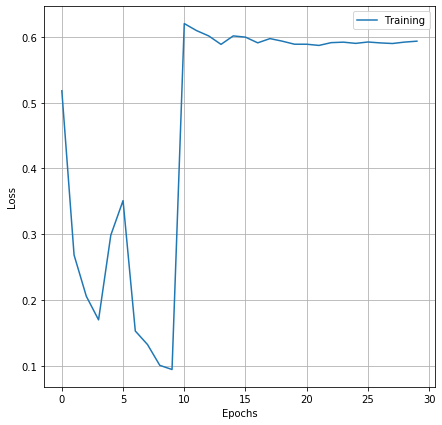

In [28]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

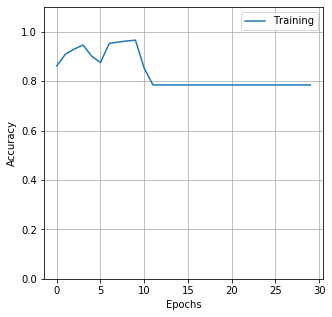

In [29]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [30]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [31]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(4044, 25, 25, 208, 1)

In [32]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(4044, 3)

In [33]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3173
           1       0.90      0.91      0.91       794
           2       0.67      0.44      0.53        77

    accuracy                           0.96      4044
   macro avg       0.85      0.78      0.81      4044
weighted avg       0.96      0.96      0.96      4044



In [34]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [35]:
def reports (X_test,y_test,name):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    if name == 'HyperChicken':
        target_names = ['Belt','Meat','Plastic']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [36]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

4044/4044 [==============================] - 30s 7ms/step


In [37]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [38]:
# load the original image
X, y = loadData(dataset)

loding stuff


In [39]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [40]:
 30 # if dataset == 'HyperChicken' else 15
# X,pca = applyPCA(X,numComponents=K)

X.shape

(100, 100, 208)

In [41]:
# X = padWithZeros(X, PATCH_SIZE//2)

In [42]:
PATCH_SIZE

25

In [43]:
# calculate the predicted image
outputs = np.zeros((height,width))

# This for-loop needs to be move to a function inorder to optimize with numba
# @jit(nopython=True, parallel=True)
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :           # TODO: What is this? And why is this?
            continue
        else :
            image_patch=Patch(X,i,j)
            n, m, k = image_patch.shape
            if image_patch.shape[0] == PATCH_SIZE and image_patch.shape[1] == PATCH_SIZE:
                X_test_image = image_patch.reshape(1, n, m, k, 1).astype('float32')
                prediction = (model.predict(X_test_image))
                prediction = np.argmax(prediction, axis=1)
                outputs[i][j] = prediction+1
            else:
                # new_patch = np.zeros((PATCH_SIZE, PATCH_SIZE, K))
                # TODO: Make this better
                prediction = -1                                
                outputs[i][j] = prediction


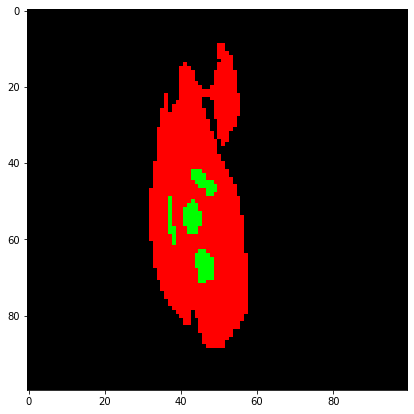

In [44]:
ground_truth = spectral.imshow(classes = np.squeeze(y),figsize =(7,7))

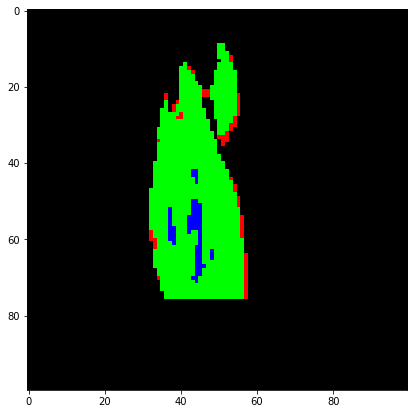

In [45]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [46]:
np.unique(outputs, return_counts=True)

(array([-1.,  0.,  1.,  2.,  3.]), array([ 169, 8587,   66, 1103,   75]))

In [47]:
data, labels, info = mypackage.Dataset.load("../../data/tomra")
# labels -= 1
# data, labels = data[0], labels[0]

In [48]:
info[0]

'20200213_120044_FM_fillet_repeat_sample_B_32'

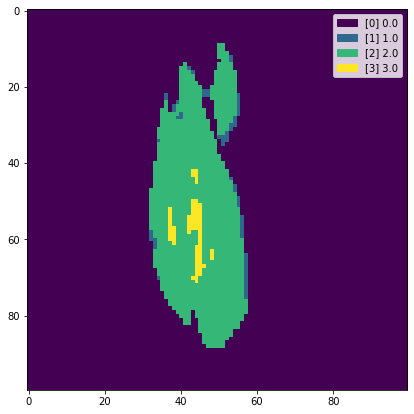

In [52]:
fixed_outputs = outputs.copy()
fixed_outputs[outputs == -1] = 2
plt.figure(figsize=(7,7))
img = plt.imshow(fixed_outputs)
mypackage.Dataset._Dataset__add_legend_to_image(fixed_outputs, img)
plt.show()

### Notes on this result
This result look disturbingly good and there is a reason for it.
1. ~~The PCA was learned on the whole dataset (train and test).~~
2. The Patches are heavily overlayed, since each pixel as a 25x25 patch around it.
3. The train/test split on patches is 70%/30% and thus all type of classes are well learned and probably most next neighbour pixels are in both classes.

But none the less this result shows that the class separation for various plastics is possible as one contaminant, and they are distinguishable from the rest.

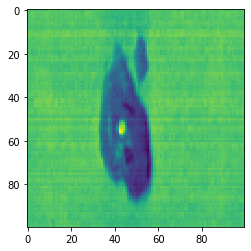

In [50]:
plt.figure()
plt.imshow(X[:, :, 7])

In [51]:
spectral.save_rgb("prediction_Stuff.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)